# Recommender Systems

What is it?

## Table of Contents

- 1- Content Filtering and Collaborative Filtering
- 2- SVD for Collaborative Filtering

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [165]:
H = {
    'debug': False,
    'n_factors': 256,
    'n_epochs': 7,
    'lr_all': 0.005,
    'weight_decay': 0.02,
    'batch_size': 128,
}

if H['debug']:
    H['n_factors'] = 20
    H['n_epochs'] = 5
    H['batch_size'] = 2

root = '.'
# root = 'ml-latest-small'
num_workers = 0

split_seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, num_workers

(device(type='cuda'), 0)

In [166]:
df = pd.read_csv(f'{root}/ratings.csv').drop('timestamp', axis=1)
if H['debug']:
    df = df[df['userId'].isin(range(10))]
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [167]:
user_ids = df['userId'].unique()
item_ids = df['movieId'].unique()

user_map = {user: idx for idx, user in enumerate(user_ids)}
item_map = {item: idx for idx, item in enumerate(item_ids)}

df['userId'] = df['userId'].map(user_map)
df['movieId'] = df['movieId'].map(item_map)

print(f'There are {len(user_ids)} unique users and {len(item_ids)} unique items in {len(df)} user-item pairs.')

There are 610 unique users and 9724 unique items in 100836 user-item pairs.


In [168]:
class UIDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.users = torch.tensor(df['userId'].values, dtype=torch.long)
        self.items = torch.tensor(df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float)
        self.ratings /= 5
        self.mu = self.ratings.mean()
        self.ratings = self.ratings - self.mu
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

    def watched_items(self, user_id):
        """
        Returns rating, item_id for watched items by user_id
        """
        watched = self.df[self.df['userId'] == user_id]
        return watched['rating'], watched['movieId'].values

    def denormalize_rating(self, rating):
        return 5 * (rating.cpu() + self.mu)

df_train, df_val = train_test_split(df, test_size=0.2, random_state=split_seed)

train_set = UIDataset(df_train)
val_set = UIDataset(df_val)

train_loader = DataLoader(train_set, batch_size=H['batch_size'], shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=H['batch_size'], shuffle=False, num_workers=num_workers)

print(f'Train size={len(train_set)}, Validation size={len(val_set)}')
len(train_loader), len(val_loader)

Train size=80668, Validation size=20168


(631, 158)

In [181]:
class CollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(CollaborativeFiltering, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.multi_head_attention = nn.MultiheadAttention(embedding_dim, 8)
        # self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_id, item_id):
        user_vec = self.user_embedding(user_id)
        item_vec = self.item_embedding(item_id)
        pred = self.multi_head_attention(user_vec, item_vec, item_vec, need_weights=False)[0]
        # pred = torch.sum(pred, dim=1, keepdim=True)
        # pred += self.user_bias(user_id) + self.item_bias(item_id)
        pred = pred[:, 0]
        pred = F.tanh(pred)
        return pred

model = CollaborativeFiltering(len(user_ids), len(item_ids), H['n_factors']).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=H['lr_all'], weight_decay=H['weight_decay'])

print(f'There are {sum(p.numel() for p in model.parameters())} parameters in the model.')
expected_num_params = len(user_ids) * H['n_factors'] + len(item_ids) * H['n_factors'] + len(user_ids) + len(item_ids) + 1
print(f'Expected: {expected_num_params}')

There are 2919006 parameters in the model.
Expected: 2655839


In [182]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    # pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc='Training')
    for idx, (user_id, item_id, rating) in enumerate(train_loader, 1):
        user_id, item_id, rating = user_id.to(device), item_id.to(device), rating.to(device)
        optimizer.zero_grad()

        preds = model(user_id, item_id)
        loss = criterion(preds, rating)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # if idx % (len(train_loader) // 10) == 0:
        #     pbar.set_postfix(batch=f'{idx}/{len(train_loader)}', loss=f'{loss.item():.4f}')

    return train_loss / len(train_loader)

@torch.no_grad()
def evaluate(model, val_loader, criterion):
    y_true = []
    y_pred = []
    model.eval()
    val_loss = 0
    for user_id, item_id, rating in val_loader:
        user_id, item_id, rating = user_id.to(device), item_id.to(device), rating.to(device)

        preds = model(user_id, item_id)
        loss = criterion(preds, rating)
        val_loss += loss.item()

        y_true.append(rating.cpu())
        y_pred.append(preds.cpu())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    r2 = r2_score(y_true, y_pred)

    return val_loss / len(val_loader), r2

def plot(train_losses, val_losses, r2s):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label='train')
    axs[0].plot(x, val_losses, label='val')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Epoch Losses')
    axs[0].set_ylim(0, 2)
    axs[1].plot(x, r2s)
    axs[1].set_title('Validation R2')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('R2')
    axs[1].set_ylim(-1, 1)
    plt.show()

Ecpoh 1/7, Train Loss: 0.1656
Val Loss: 0.1664, R^2 Score: 0.0000
Ecpoh 2/7, Train Loss: 0.1654
Val Loss: 0.1663, R^2 Score: -0.0000
Ecpoh 3/7, Train Loss: 0.1654
Val Loss: 0.1666, R^2 Score: -0.0022
Ecpoh 4/7, Train Loss: 0.1655
Val Loss: 0.1671, R^2 Score: -0.0002
Ecpoh 5/7, Train Loss: 0.1655
Val Loss: 0.1665, R^2 Score: -0.0008
Ecpoh 6/7, Train Loss: 0.1654
Val Loss: 0.1664, R^2 Score: -0.0002
Ecpoh 7/7, Train Loss: 0.1654
Val Loss: 0.1665, R^2 Score: -0.0013


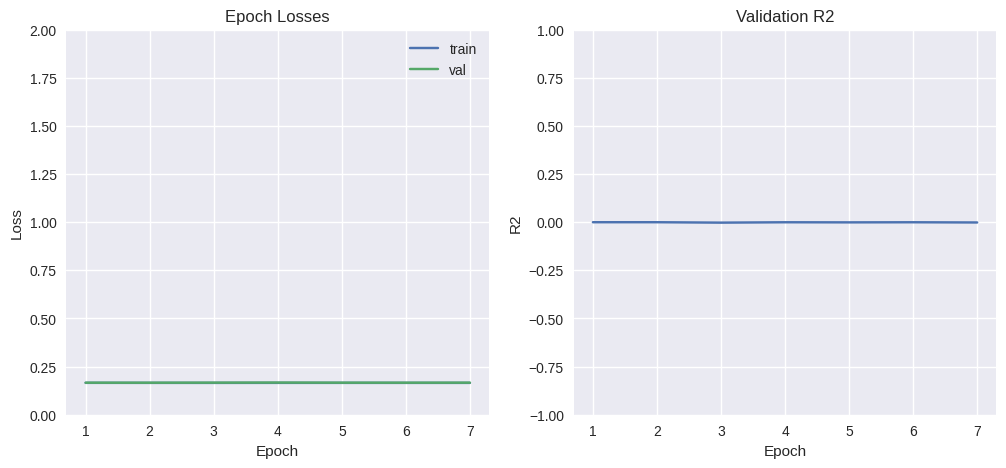

In [183]:
train_losses = []
val_losses = []
r2s = []

for epoch in range(1, 1+H['n_epochs']):
    train_loss = train(model, train_loader, criterion, optimizer)
    print(f'Ecpoh {epoch}/{H["n_epochs"]}, Train Loss: {train_loss:.4f}')
    val_loss, r2 = evaluate(model, val_loader, criterion)
    print(f"Val Loss: {val_loss:.4f}, R^2 Score: {r2:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    r2s.append(r2)

plot(train_losses, val_losses, r2s)

In [184]:
@torch.no_grad()
def recommend_for_user(user_id):
    real_ratings, candidate_items = val_set.watched_items(user_id)
    user_idx = user_map[user_id]
    user_tensor = torch.tensor(user_idx, dtype=torch.long).repeat(len(candidate_items))
    item_tensor = torch.tensor(candidate_items, dtype=torch.long)
    pred_ratings = model(user_tensor.to(device), item_tensor.to(device))
    pred_ratings = val_set.denormalize_rating(pred_ratings)
    result = pd.DataFrame({
        'Item Id': candidate_items,
        'Real Rating': real_ratings,
        'Pred Rating': pred_ratings
    })
    return result

result = recommend_for_user(1)
result

,Item Id,Real Rating,Pred Rating
4169,248,5.0,3.535589
6315,251,3.5,3.535589
15162,237,4.0,3.535589
17260,254,4.0,3.535589
